In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='10_class_ds.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('10_class_ds.zip')
f.keys()
!unzip "10_class_ds.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_3.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_4.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_5.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_0.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_3.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_4.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_5.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_0.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_3.jpg  
  inflating: 10_cla

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
data_dir = '/content/10_class_ds'


train_df, valid_df, test_df = split_data(data_dir)

batch_size = 40

train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 8877 validated image filenames belonging to 10 classes.
Found 1110 validated image filenames belonging to 10 classes.
Found 1110 validated image filenames belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomZoom(height_factor=0.2)

    ],
    name="img_augmentation",
)

Found 11097 files belonging to 10 classes.


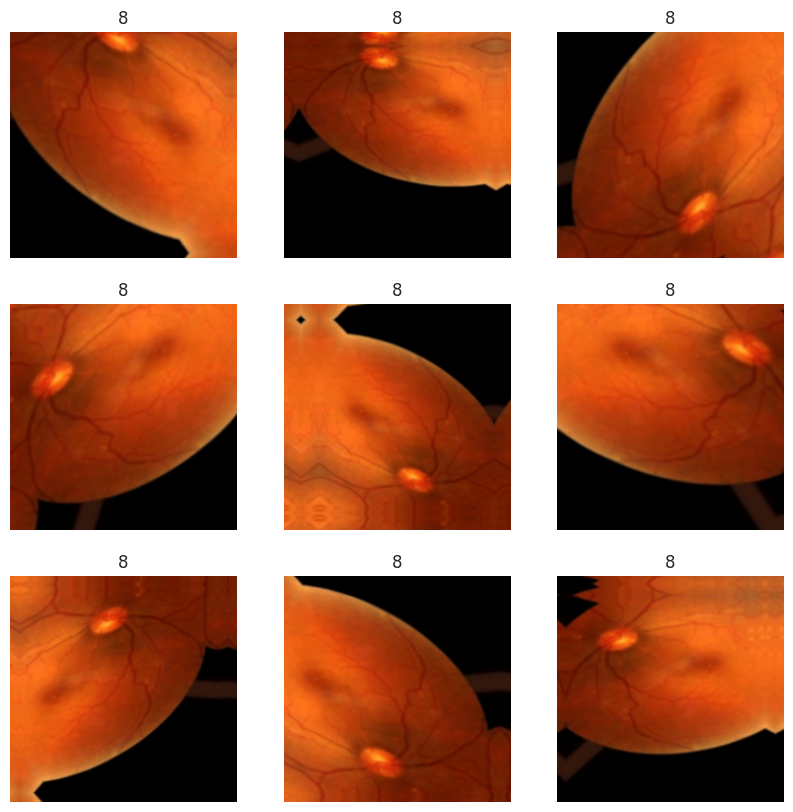

In [ ]:
import numpy as np

dataset = tf. keras.preprocessing. image_dataset_from_directory(
'/content/10_class_ds',
shuffle=True,
image_size = (224, 224) ,
batch_size=32
)

for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                         

In [ ]:
history = model.fit(train_gen, epochs= 100,
                    validation_data= valid_gen)

Epoch 1/100
222/222 [==============================] - 220s 676ms/step - loss: 6.1173 - accuracy: 0.8735 - val_loss: 4.1405 - val_accuracy: 0.9568
Epoch 2/100
222/222 [==============================] - 147s 660ms/step - loss: 3.0880 - accuracy: 0.9621 - val_loss: 2.2024 - val_accuracy: 0.9640
Epoch 3/100
222/222 [==============================] - 147s 663ms/step - loss: 1.6641 - accuracy: 0.9692 - val_loss: 1.1832 - val_accuracy: 0.9640
Epoch 4/100
222/222 [==============================] - 151s 681ms/step - loss: 0.9178 - accuracy: 0.9765 - val_loss: 0.6783 - val_accuracy: 0.9694
Epoch 5/100
222/222 [==============================] - 147s 662ms/step - loss: 0.5667 - accuracy: 0.9793 - val_loss: 0.4665 - val_accuracy: 0.9694
Epoch 6/100
222/222 [==============================] - 146s 659ms/step - loss: 0.3895 - accuracy: 0.9863 - val_loss: 0.3478 - val_accuracy: 0.9739
Epoch 7/100
222/222 [==============================] - 147s 662ms/step - loss: 0.3249 - accuracy: 0.9852 - val_loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


15/15 [==============================] - 8s 335ms/step - loss: 0.4529 - accuracy: 0.9721
Test Loss: 0.4529
Test Accuracy: 0.9721


In [ ]:
dataset = '/content/10_class_ds'

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.10,
                                                                 subset='validation',
                                                                 seed=66)

Found 11097 files belonging to 10 classes.
Using 1109 files for validation.


In [ ]:
class_names = validation_dataset.class_names
class_names

['Choroidal neovascularization',
 'acrima',
 'cataract',
 'diabetic_macular_edema_(dme)',
 'diabetic_retinopathy',
 'drusen',
 'glaucoma',
 'normal',
 'odir_5k',
 'origa']

first image to predict
actual label: odir_5k
1/1 [==============================] - 0s 39ms/step
predicted label: odir_5k


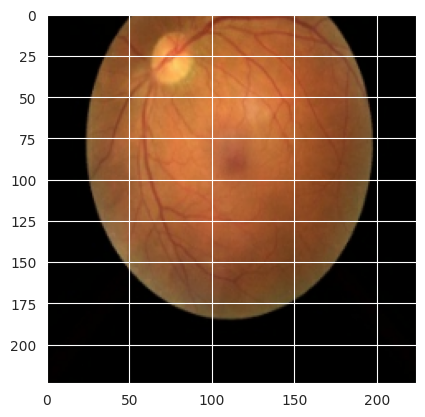

In [ ]:
import numpy as np
for images_batch, labels_batch in validation_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


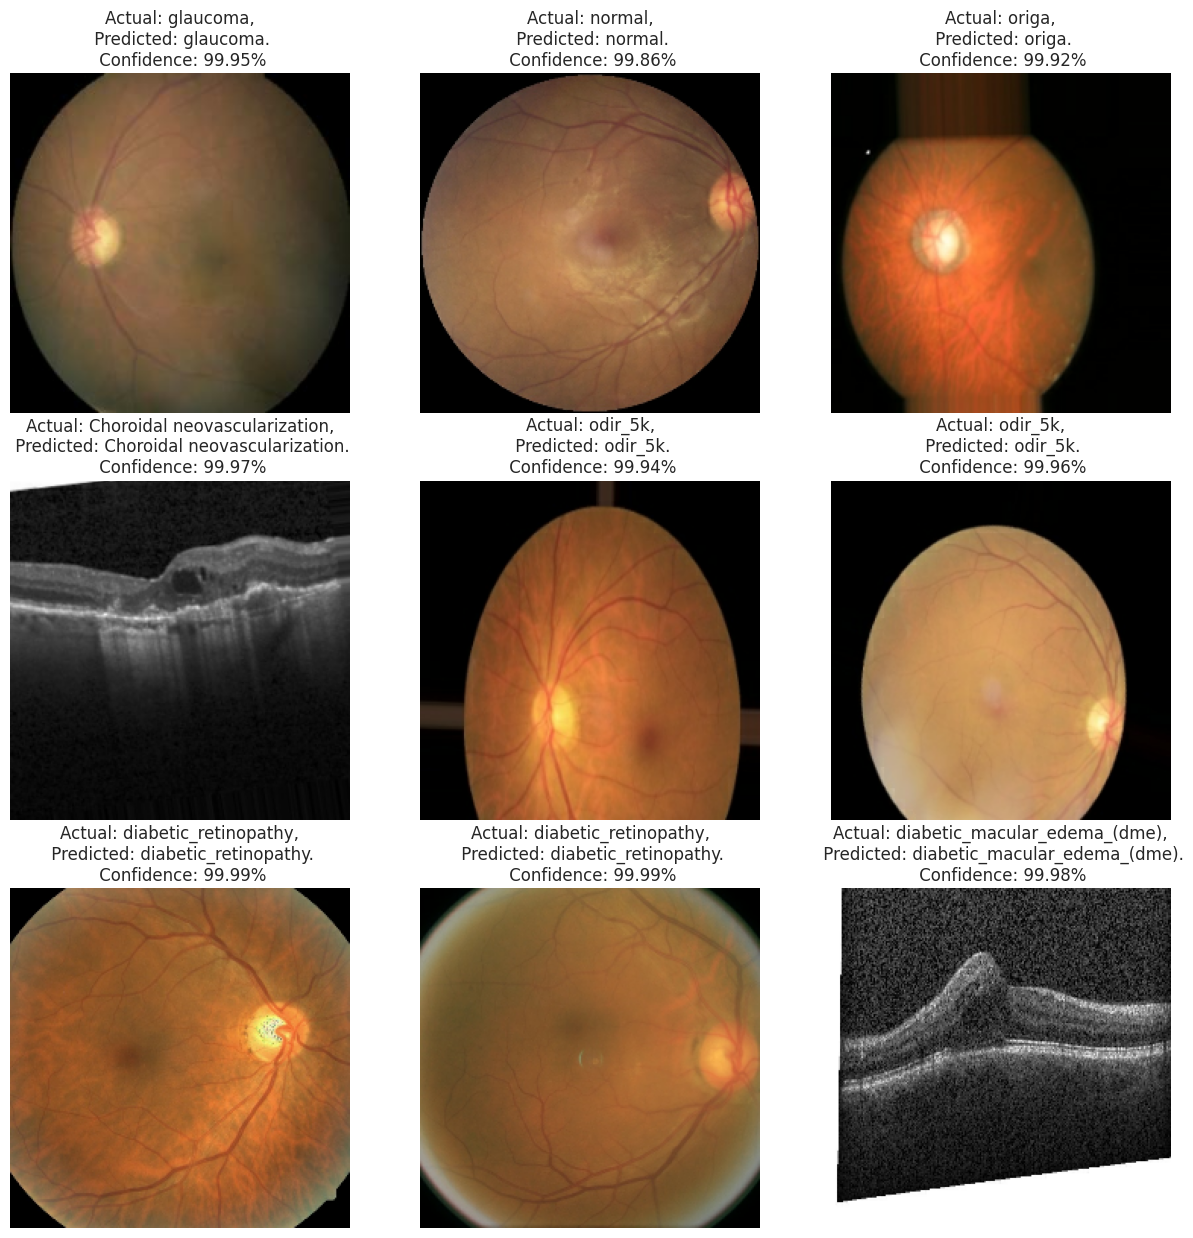

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


1/1 [==============================] - 0s 32ms/step
F1 Score: 0.9963218450315734
Precision: 0.9968324532438079
Recall: 0.995844454918203
ROC-AUC Score: 0.9984562279109287


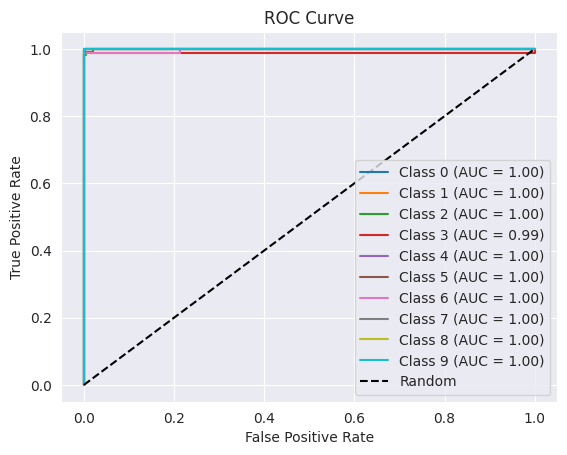

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


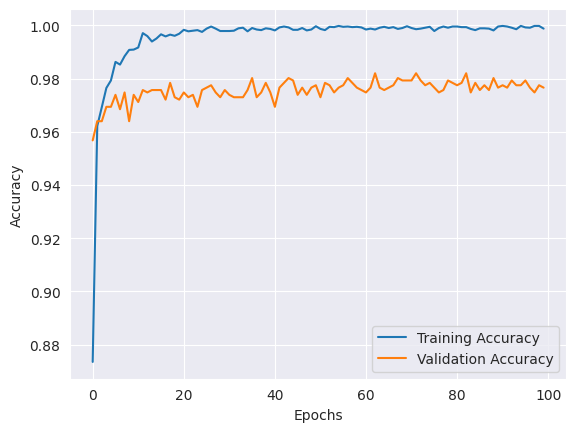

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracies
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 30ms/step


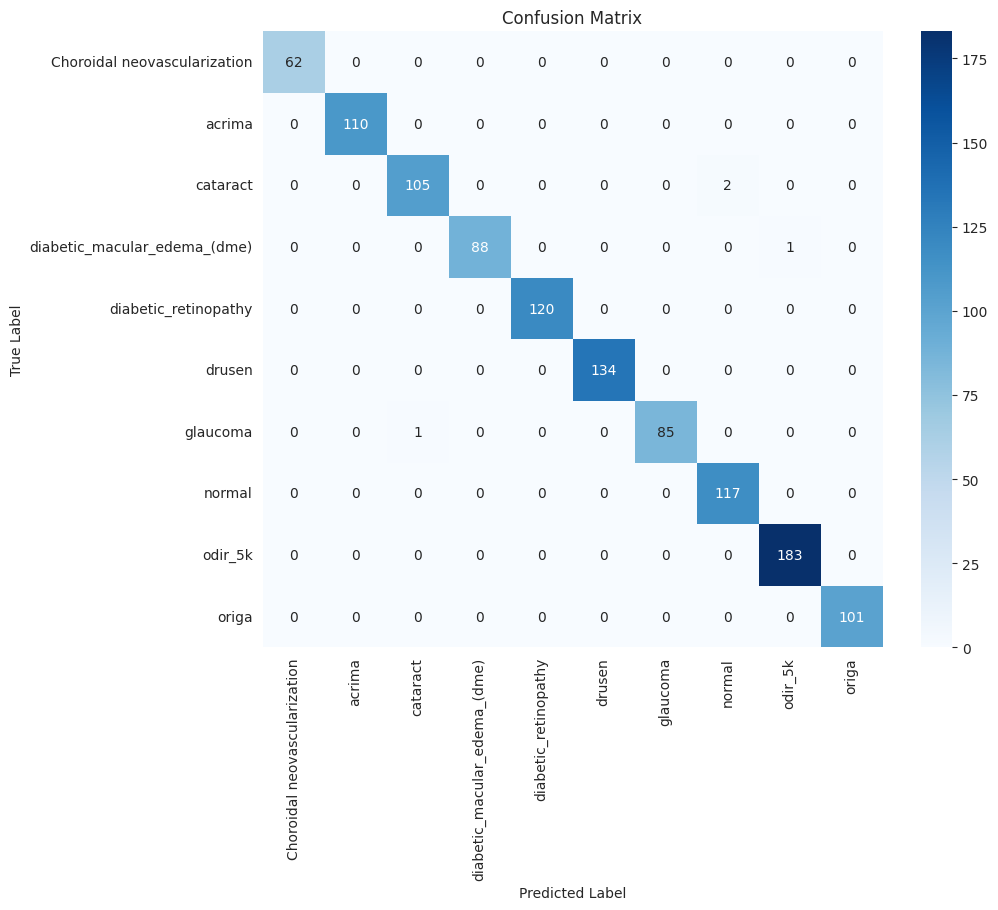

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset
#class_names = test_dataset.class_names

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()